# 소득 예측 모델 만들기

## 예측 변수(predictor variable)
예측하는 데 활용하는 변수 또는 모델에 입력하는 값(input)


## 타겟 변수
예측하고자 하는 변수 또는 모델이 출력하는 값(output)

In [1]:
import pandas as pd

# 48842명의 정보를 담고 있으면 변수 15개로 구성되어있다.
# `income` : 타겟 변수
# 그 외 : 예측 변수
df = pd.read_csv("../data/adult.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


# 전처리하기

## # 1. 타겟 변수 전처리
### income 은 조사 응답자의 연소득이 5만 달러를 초과하는지 여부를 나타낸다.

In [2]:
# normalize = True 를 입력하면 범주의 비율을 구한다.
df.income.value_counts(normalize=True)

income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

In [3]:
# 변수의 값에 특수 문자나 대소문자가 섞여 있으면 다루기 불편하므로 초과는 `high`, 그렇지 않으면 `log`
import numpy as np

df["income"] = np.where(df["income"] == ">50K", "high", "low")
df["income"].value_counts(normalize=True)

income
low     0.760718
high    0.239282
Name: proportion, dtype: float64

## 2. 불필요한 변수 제거
### 이름, 아이디, 주소 같은 변수는 대부의 값이 고유값이어서 타겟 변수와 관련성이 없다.

In [4]:
# `fnlwgt` 는 `adult` 데이터를 이용해 미국의 실제 인구를 추정할 때 사용하는 가중치이다.
df = df.drop(columns="fnlwgt")
df

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,low
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,low
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,high
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,high
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,low
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,high
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,low
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,low


## 3. 문자 타입을 숫자 타입으로 바꾸기
### 모델을 만드는 데 사용되는 모든 변수는 숫자 타입이어야 한다.

#### 원핫 인코딩
변수의 범주가 특정 값이면 1, 그렇지 않으면 0으로 바꾸는 것

In [5]:
df_tmp = df[["sex"]]
df_tmp.sex.value_counts()

sex
Male      32650
Female    16192
Name: count, dtype: int64

In [6]:
# pd.get_dummies() 에 데이터 프레임을 입력하면 문자 타입 변수를 원핫 인코딩을 적용해 변환한다.
df_tmp = pd.get_dummies(df_tmp)
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   sex_Female  48842 non-null  bool 
 1   sex_Male    48842 non-null  bool 
dtypes: bool(2)
memory usage: 95.5 KB


In [7]:
# income 만 제외하고 모둔 원핫 인코딩을 하기 위해 `income` 추출 후 변환하고 다시 삽입
target = df["income"]  # income 추출

df = df.drop(columns="income")  # income 제거
df = pd.get_dummies(df)  # 문자 타입 변수 원핫 인코딩

df["income"] = target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Columns: 108 entries, age to income
dtypes: bool(102), int64(5), object(1)
memory usage: 7.0+ MB


## 4. 데이터 분할하기
### 모든 데이터를 사용해 모델을 만들면 성능 평가 점수를 신뢰할 수 없다.

---
### 크로스 밸리데이션(cross validation, 교차 검증)
데이터를 분할해 일부는 모델을 만들 때 사용하고 나머지는 평가할 때 사용하는 방법

---
### 트레이닝 세트(training set, 훈련 세트) 
분할한 데이터 중에서 모델을 만들 떄 사용하는 데이터

---
### 테스트 세트(test set, 시험 세트)
성능을 평가할 때 사용하는 데이터

In [8]:
# adult 데이터 분할하기
# 트레이닝 세트와 테스트 세트의 비율은 보통 7:3 에서 8:2 로 정한다.
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.3,  # 테스트 세트 비율
    stratify=df["income"],  # 타겟 변수 비율 고정
    random_state=1234,  # 난수 고정
)

In [9]:
# train
df_train.shape

(34189, 108)

In [10]:
# test
df_test.shape

(14653, 108)

# 의자결정나무 모델 만들기(decision tree)

In [11]:
# 모델 만들 때 -> df_train
# 모델 평가 -> df_test

from sklearn import tree

# 모델 설정하기
# clf : classifier | 저소득/고소득처럼 데이터를 몇 개 중 하나로 분류하는 모델
clf = tree.DecisionTreeClassifier(
    random_state=1234, max_depth=3  # 난수 고정  # 나무 깊이
)

# 모델 만들기
tranin_x = df_train.drop(columns="income")  # 예측 변수 추출
tranin_y = df_train["income"]  # 타겟 변수 추출

model = clf.fit(X=tranin_x, y=tranin_y)

[Text(0.5, 0.875, 'x[32] <= 0.5\ngini = 0.364\nsamples = 34189\nvalue = [8181, 26008]'),
 Text(0.25, 0.625, 'x[2] <= 7073.5\ngini = 0.12\nsamples = 18525\nvalue = [1187, 17338]'),
 Text(0.125, 0.375, 'x[1] <= 13.5\ngini = 0.092\nsamples = 18210\nvalue = [885, 17325]'),
 Text(0.0625, 0.125, 'gini = 0.071\nsamples = 17204\nvalue = [637, 16567]'),
 Text(0.1875, 0.125, 'gini = 0.371\nsamples = 1006\nvalue = [248, 758]'),
 Text(0.375, 0.375, 'x[0] <= 20.0\ngini = 0.079\nsamples = 315\nvalue = [302, 13]'),
 Text(0.3125, 0.125, 'gini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.4375, 0.125, 'gini = 0.056\nsamples = 310\nvalue = [301, 9]'),
 Text(0.75, 0.625, 'x[1] <= 12.5\ngini = 0.494\nsamples = 15664\nvalue = [6994, 8670]'),
 Text(0.625, 0.375, 'x[2] <= 5095.5\ngini = 0.442\nsamples = 11002\nvalue = [3634.0, 7368.0]'),
 Text(0.5625, 0.125, 'gini = 0.418\nsamples = 10472\nvalue = [3115.0, 7357.0]'),
 Text(0.6875, 0.125, 'gini = 0.041\nsamples = 530\nvalue = [519, 11]'),
 Text(0.875, 0.375,

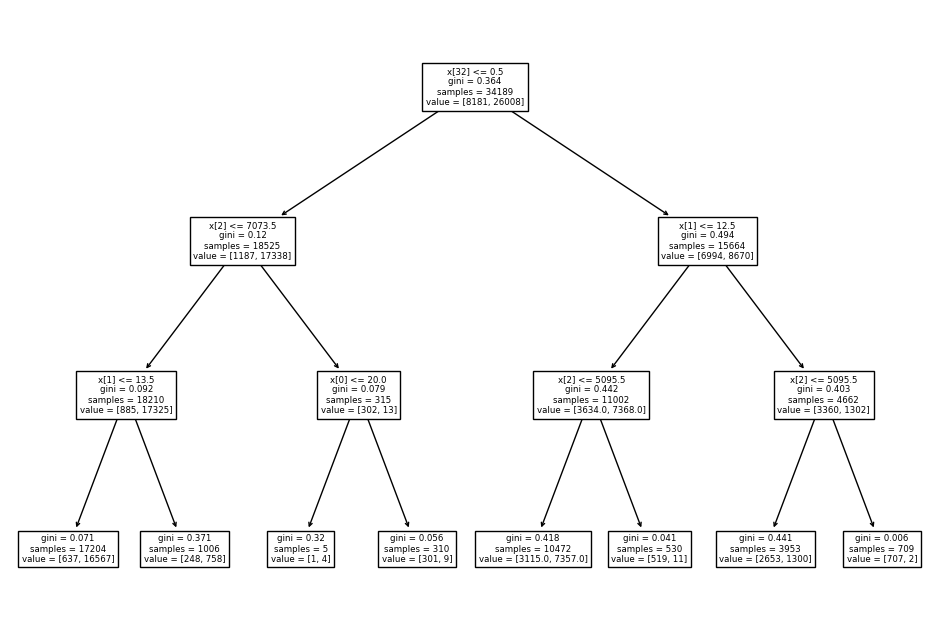

In [12]:
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.dpi": "100", "figure.figsize": [12, 8]})

tree.plot_tree(model)

[Text(0.5, 0.875, 'marital_status_Married-civ-spouse <= 0.5\nsamples = 100.0%\nvalue = [0.239, 0.761]\nclass = low'),
 Text(0.25, 0.625, 'capital_gain <= 7073.5\n54.2%\n[0.064, 0.936]\nlow'),
 Text(0.125, 0.375, 'education_num <= 13.5\n53.3%\n[0.049, 0.951]\nlow'),
 Text(0.0625, 0.125, '50.3%\n[0.037, 0.963]\nlow'),
 Text(0.1875, 0.125, '2.9%\n[0.247, 0.753]\nlow'),
 Text(0.375, 0.375, 'age <= 20.0\n0.9%\n[0.959, 0.041]\nhigh'),
 Text(0.3125, 0.125, '0.0%\n[0.2, 0.8]\nlow'),
 Text(0.4375, 0.125, '0.9%\n[0.971, 0.029]\nhigh'),
 Text(0.75, 0.625, 'education_num <= 12.5\n45.8%\n[0.447, 0.553]\nlow'),
 Text(0.625, 0.375, 'capital_gain <= 5095.5\n32.2%\n[0.33, 0.67]\nlow'),
 Text(0.5625, 0.125, '30.6%\n[0.297, 0.703]\nlow'),
 Text(0.6875, 0.125, '1.6%\n[0.979, 0.021]\nhigh'),
 Text(0.875, 0.375, 'capital_gain <= 5095.5\n13.6%\n[0.721, 0.279]\nhigh'),
 Text(0.8125, 0.125, '11.6%\n[0.671, 0.329]\nhigh'),
 Text(0.9375, 0.125, '2.1%\n[0.997, 0.003]\nhigh')]

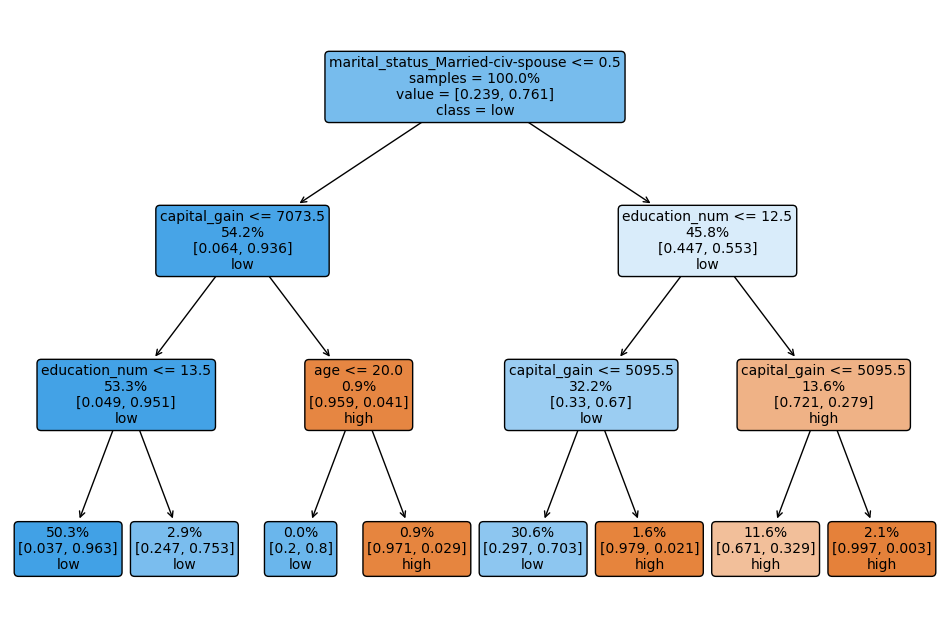

In [13]:
tree.plot_tree(
    model,
    feature_names=list(tranin_x.columns),
    class_names=["high", "low"],
    proportion=True,
    filled=True,
    rounded=True,
    impurity=False,
    label="root",
    fontsize=10,
)